# Predicting Continuous Error Rate in BOMARE SMT Feeder Setup

## Data Loading and Preprocessing

In this section, we load the feeder setup and part usage data, then perform essential preprocessing steps. This includes handling missing values, normalizing positions, and ensuring no target leakage. The datasets are expected to contain information about feeder configurations and part usage metrics, which will be used to predict the continuous `ErrorRate`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
import joblib


Assuming that `FeederSetup.csv` and `PartUsage.csv` share a common key (such as `FeederID` or `PartNumber`), we join them to form a single dataframe.

In [2]:
def normalize_position(pos: str) -> str:
    """
    Normalize positions of the form:
      MXX-<SEG1>-<SEG2>-... 
    by
      - stripping leading zeros from the M## part
      - stripping leading zeros from every subsequent numeric segment
      - preserving any letter‐segments intact (but still strip any leading zeros in them)
    Examples:
      'M06-A-03-01'   → 'M6-A-3-1'
      'M6-B-10-02-5' → 'M6-B-10-2-5'
    """
    parts = pos.split('-')
    # must start with M<number>
    if not parts or not parts[0].startswith('M'):
        return pos.strip()
    # normalize the module segment: 'M06' → 'M6'
    mod_num = parts[0][1:].lstrip('0') or '0'
    new_parts = [f"M{mod_num}"]
    # normalize each subsequent segment
    for seg in parts[1:]:
        seg = seg.strip()
        # if purely numeric or numeric‐letter combo, strip leading zeros
        # e.g. '03'→'3', 'A'→'A'
        normalized = seg.lstrip('0') or seg  # if seg was all zeros, keep one '0'
        new_parts.append(normalized)
    return "-".join(new_parts)

def explode_positions(df: pd.DataFrame) -> pd.DataFrame:
    """
    1) Normalize Position
    2) Split on commas
    3) Explode to one row per Position
    """
    df = df.copy()
    # Step 1: normalize & split
    df['Position'] = (
        df['Position']
        .astype(str)
        .apply(lambda s: [ normalize_position(p) for p in s.split(',') ])
    )
    # Step 2: explode
    return df.explode('Position').reset_index(drop=True)

# Usage:
import pandas as pd

part_usage   = pd.read_csv("PartUsage.csv")
feeder_setup = pd.read_csv("FeederSetup.csv")

# build Position as before
fs = feeder_setup.copy()
fs['Location'] = fs['Location'].astype(str).str.replace("'", "")
fs['Position'] = 'M' + fs['ModuleNumber'].astype(str) + '-' + fs['Location']

# explode both
pu = explode_positions(part_usage)
fs = explode_positions(fs)

print("part_usage shape:", pu.shape)
print("feeder_setup shape:", fs.shape)

# Quick check
print("Unique FeederSetup positions (first 20):")
print(fs['Position'].unique()[:20])
print("Unique PartUsage positions (first 20):")
print(pu['Position'].unique()[:20])


part_usage shape: (959, 21)
feeder_setup shape: (664, 26)
Unique FeederSetup positions (first 20):
['M1.0-1' 'M1.0-2' 'M1.0-3' 'M1.0-4' 'M1.0-5' 'M1.0-6' 'M1.0-7' 'M1.0-8'
 'M1.0-9' 'M1.0-10' 'M1.0-11' 'M1.0-12' 'M1.0-13' 'M1.0-14' 'M1.0-15'
 'M1.0-16' 'M1.0-17' 'M1.0-18' 'M1.0-19' 'M1.0-20']
Unique PartUsage positions (first 20):
['M3-20' 'M3-17' 'M5-38' 'M3-7' 'M3-33' 'M5-40' 'M5-43' 'M2-2' 'M2-21'
 'M5-42' 'M3-28' 'M2-3' 'M3-21' 'M4-39' 'M2-20' 'M3-34' 'M3-19' 'M3-18'
 'M4-40' 'M2-28']


In [4]:
# ────────────────────────────────────────────────────────────────
# ► Merge & Clean
# ────────────────────────────────────────────────────────────────
fs = feeder_setup.copy()
fs['ModuleNumber'] = fs['ModuleNumber'].fillna(0).astype(int)
fs.rename(columns={'PartShapeName':'Shape'}, inplace=True)
fs['Location'] = fs['Location'].astype(str).str.replace("'", "")
fs['Position'] = 'M' + fs['ModuleNumber'].astype(int).astype(str) + '-' + fs['Location']

# Explode Positions as before...
fs = explode_positions(fs)
pu = explode_positions(part_usage)

# Inner‐merge on Position,PartNumber,Shape
df = fs.merge(pu, on=['Position','PartNumber','Shape'], how='left')

# Drop pure‐leakage & constant columns
to_drop = [
    'NoPick','Usage','Reject','Dislodge','Rescan','LCR',
    'Pickup Rate','Reject Rate','Dislodge Rate',
    'PMADC','ChuteType','AVLNAME','AVL','OrderNum','SideNo','FeederID',
    'PMABAR','Location','SetupName','ModuleNumber',
    'ModelName','LineName','PartNumberImage','PartComment'
]
df.drop(columns=[c for c in to_drop if c in df.columns], inplace=True)

# ────────────────────────────────────────────────────────────────
# ► Drop rows missing any key identifiers
# ────────────────────────────────────────────────────────────────
before = len(df)
df.dropna(subset=['Position','PartNumber'], inplace=True)
after = len(df)
print(f"Dropped {before-after} rows missing Position/PartNumber/Shape")

# ────────────────────────────────────────────────────────────────
# ► Compute & Impute ErrorRate
# ────────────────────────────────────────────────────────────────
# Convert the raw 'Error Rate' column if present
df['ErrorRate'] = pd.to_numeric(df.get('Error Rate', np.nan), errors='coerce')

# Flag history missing
df['HistoryMissing'] = df['ErrorRate'].isna().astype(int)
n_missing = df['HistoryMissing'].sum()
pct_missing = n_missing / len(df) * 100
print(f"Rows with missing history: {n_missing} / {len(df)} ({pct_missing:.1f}%)")

# First‐pass: group mean by Shape+Position
group_means = (df
               .groupby(['Shape','Position'])['ErrorRate']
               .mean()
               .rename('GroupMean')
              )
df = df.join(group_means, on=['Shape','Position'])

# Fill ErrorRate: use GroupMean, then global mean
global_mean = df['ErrorRate'].mean()
df['ErrorRate'] = df['ErrorRate'].fillna(df['GroupMean'])
df['ErrorRate'] = df['ErrorRate'].fillna(global_mean)

print(f"Imputed missing ErrorRate with group means and global mean = {global_mean:.4f}")

# Drop the helper column
df.drop(columns=['GroupMean'], inplace=True)

df.head()
print("after cleanup:", df.shape)
print("columns:", df.columns.tolist())

# 11) save final
df.to_csv("df.csv", index=False)


Dropped 297 rows missing Position/PartNumber/Shape
Rows with missing history: 2 / 367 (0.5%)
Imputed missing ErrorRate with group means and global mean = 0.4125
after cleanup: (367, 22)
columns: ['PartNumber', 'FeederName', 'Status', 'Shape', 'PackageName', 'FeederType', 'TapeWidth', 'FeedPitch', 'PTPMNH', 'FeederQTY', 'Position', 'VT', 'SizeX', 'SizeY', 'Height', 'FIDL', 'Pickup', 'Error', 'Error Rate', 'Success Rate', 'ErrorRate', 'HistoryMissing']


Next, we handle missing values and drop any columns that could cause target leakage.

In [5]:
# Identify missing values
print(df.isnull().sum())

# Example: Drop columns with too many missing values or not useful
df = df.drop(columns=['SomeIrrelevantColumn'], errors='ignore')

# Impute missing values for numeric and categorical
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# Ensure no target leakage: drop columns that are derived from ErrorRate or occur after it
# For example, if there is a column computed from actual error, drop it
df = df.drop(columns=['LeakageColumn1', 'LeakageColumn2'], errors='ignore')
display(df.info())

PartNumber         0
FeederName        20
Status             0
Shape              0
PackageName        0
FeederType         0
TapeWidth          0
FeedPitch          0
PTPMNH             0
FeederQTY          0
Position           0
VT                 2
SizeX              2
SizeY              2
Height             2
FIDL              21
Pickup             2
Error              2
Error Rate         2
Success Rate       2
ErrorRate          0
HistoryMissing     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 367 entries, 10 to 663
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PartNumber      367 non-null    object 
 1   FeederName      367 non-null    object 
 2   Status          367 non-null    object 
 3   Shape           367 non-null    object 
 4   PackageName     367 non-null    object 
 5   FeederType      367 non-null    object 
 6   TapeWidth       367 non-null    object 
 7   FeedPitch     

None

## Exploratory Data Analysis (EDA)

We start with a thorough exploration of the data, visualizing the distributions of both numerical and categorical features, and examining their relationships with the `ErrorRate`.

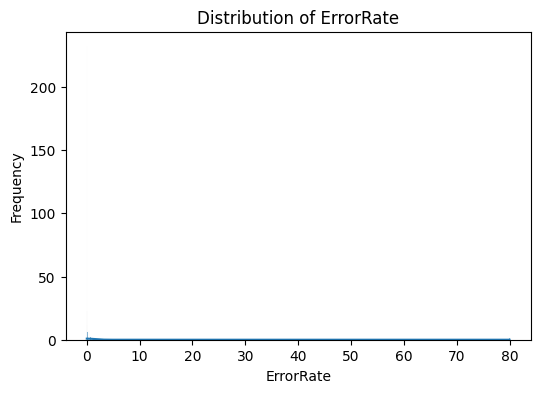

In [6]:
# Distribution of the target variable (ErrorRate)
plt.figure(figsize=(6,4))
sns.histplot(df['ErrorRate'], kde=True)
plt.title('Distribution of ErrorRate')
plt.xlabel('ErrorRate')
plt.ylabel('Frequency')
plt.show()

### Numeric Features Distribution

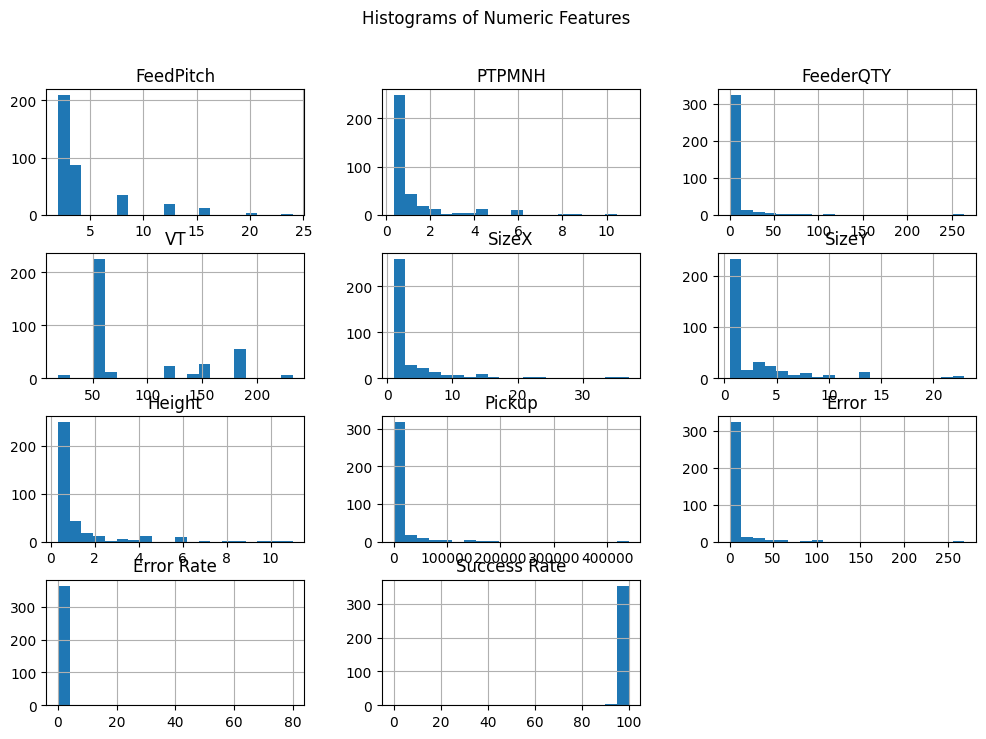

In [7]:
num_features = df.select_dtypes(include=['float64', 'int64']).drop(columns=['ErrorRate']).columns
df[num_features].hist(figsize=(12, 8), bins=20)
plt.suptitle('Histograms of Numeric Features')
plt.show()

### Categorical Features Distribution

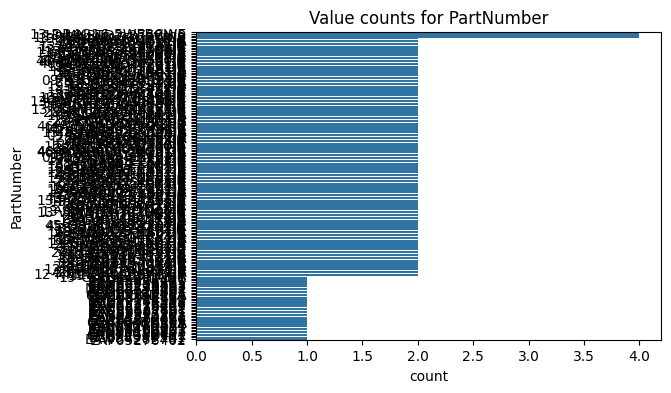

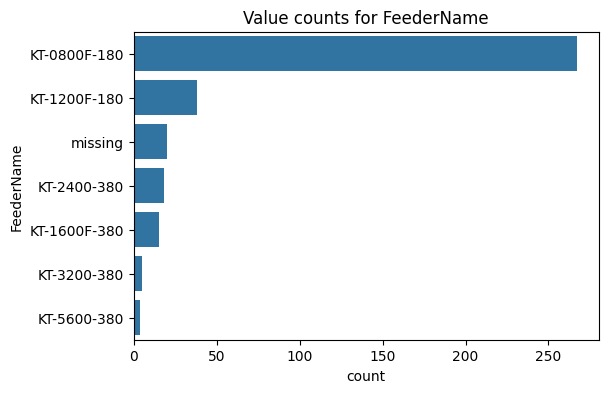

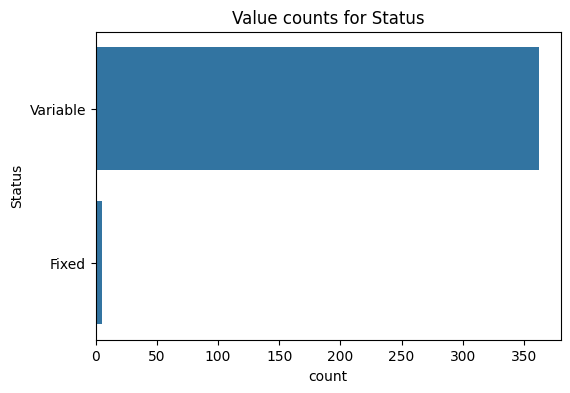

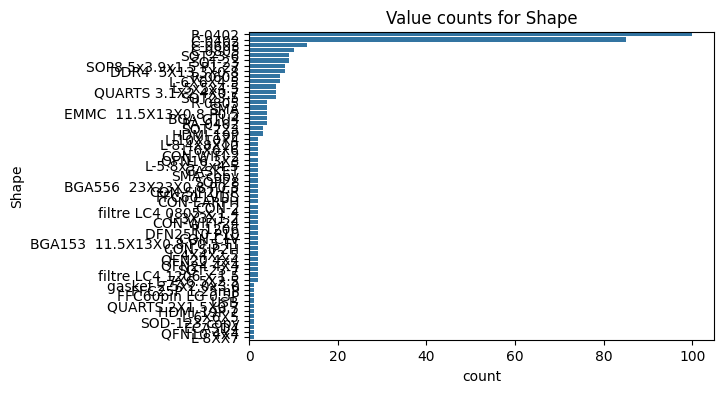

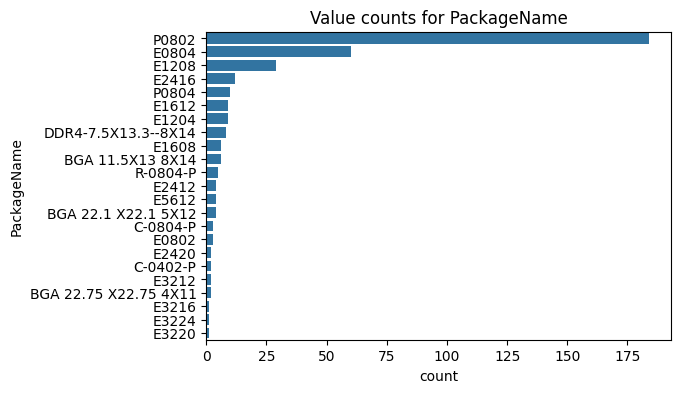

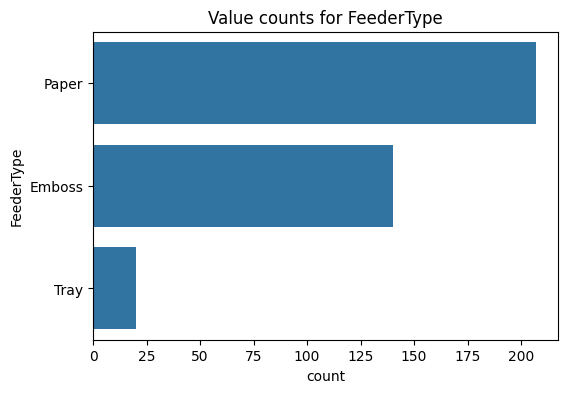

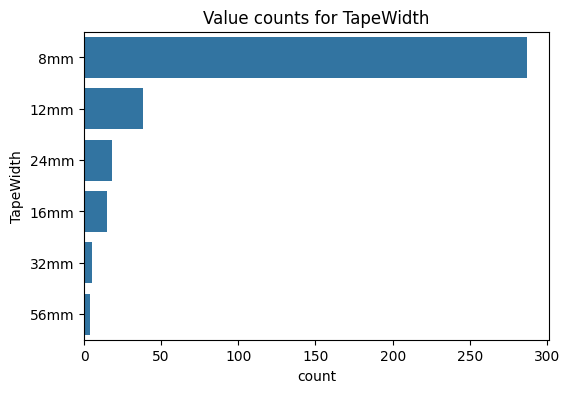

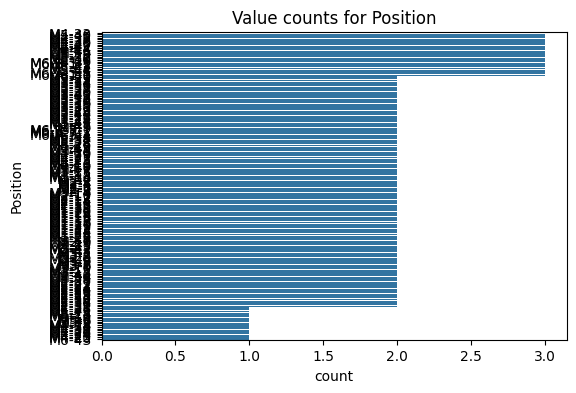

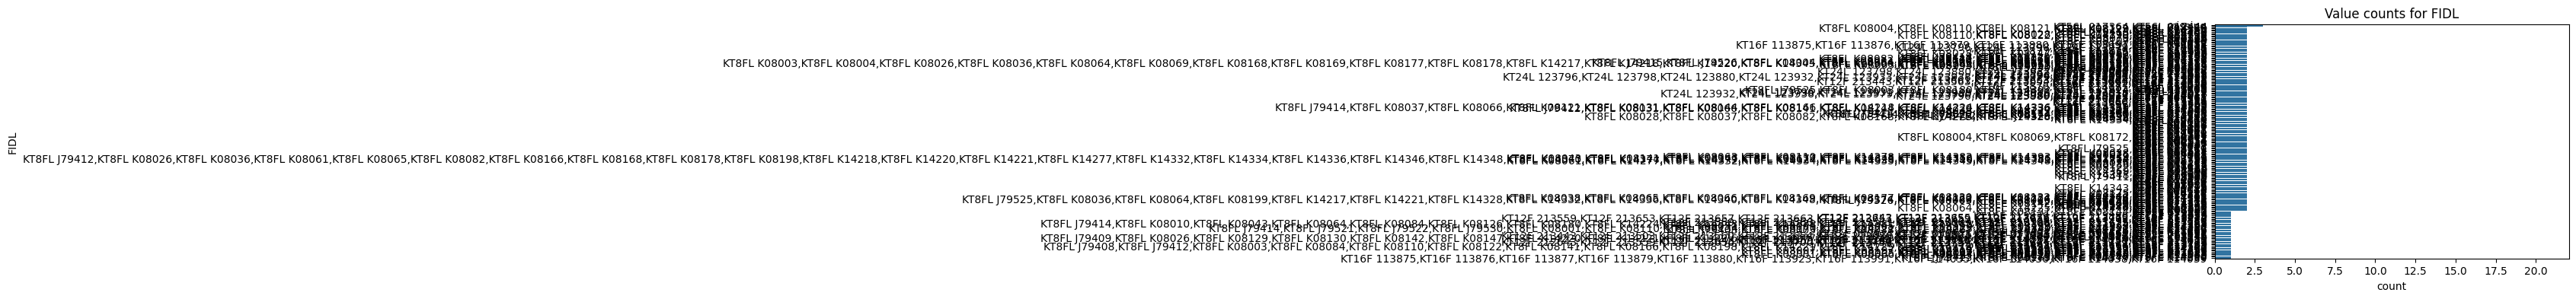

In [8]:
cat_features = df.select_dtypes(include=['object', 'category']).columns
for col in cat_features:
    plt.figure(figsize=(6,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Value counts for {col}')
    plt.show()

### Correlation Analysis

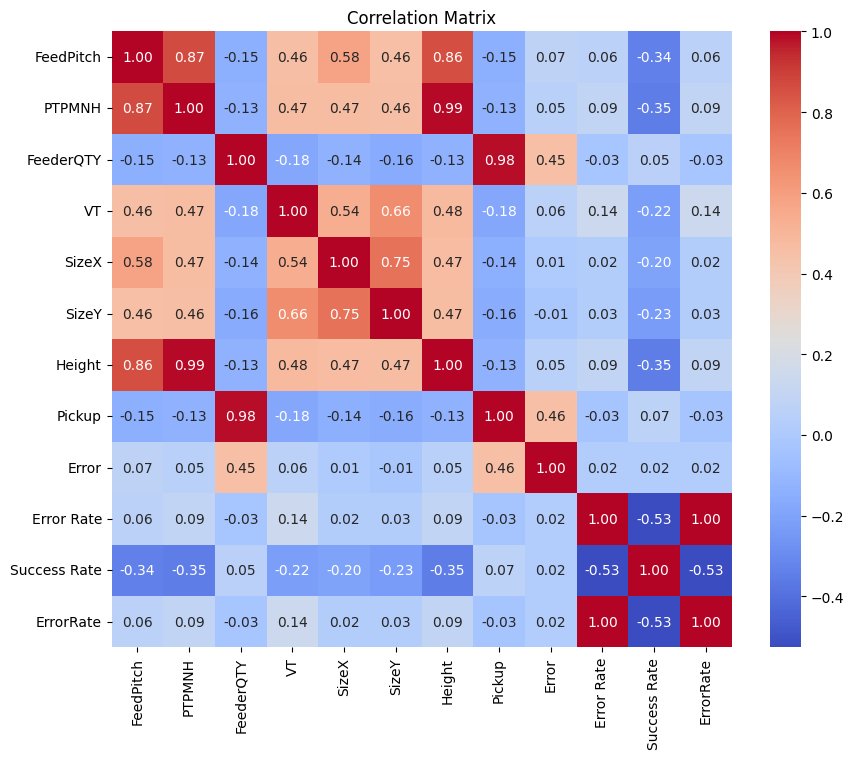

In [9]:
# Correlation matrix for numeric features
corr_matrix = df[num_features.tolist() + ['ErrorRate']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

We further inspect relationships between top correlated features and `ErrorRate`.

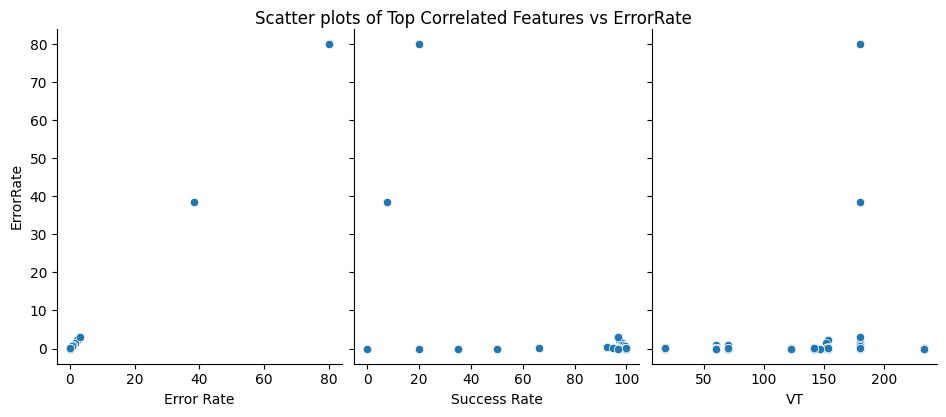

In [10]:
# Identify top 3 correlated features with ErrorRate
target_corr = corr_matrix['ErrorRate'].abs().sort_values(ascending=False)
top_features = target_corr.index[1:4]
sns.pairplot(df, x_vars=top_features, y_vars='ErrorRate', height=4, aspect=0.8)
plt.suptitle('Scatter plots of Top Correlated Features vs ErrorRate', y=1.02)
plt.show()

## Feature Engineering

We create new features to help the models capture complex relationships. This includes aggregated statistics by part or feeder group, and interaction terms.

In [11]:

if 'PartNumber' in df.columns:
    part_mean_error = df.groupby('PartNumber')['ErrorRate'].transform('mean')
    df['PartNumber_MeanError'] = part_mean_error

if 'FeatureA' in df.columns and 'FeatureB' in df.columns:
    df['FeatureA_FeatureB'] = df['FeatureA'] * df['FeatureB']

# Update feature lists after engineering
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.drop('ErrorRate')
categorical_features = df.select_dtypes(include=['object', 'category']).columns
numeric_features, categorical_features

(Index(['FeedPitch', 'PTPMNH', 'FeederQTY', 'VT', 'SizeX', 'SizeY', 'Height',
        'Pickup', 'Error', 'Error Rate', 'Success Rate',
        'PartNumber_MeanError'],
       dtype='object'),
 Index(['PartNumber', 'FeederName', 'Status', 'Shape', 'PackageName',
        'FeederType', 'TapeWidth', 'Position', 'FIDL'],
       dtype='object'))

## Preparing Data for Modeling

We split the data into features and target, then into training and testing sets. We also set up preprocessing pipelines for numeric and categorical features.

In [12]:
# Define feature matrix X and target y
X = df.drop(columns=['ErrorRate'])
y = df['ErrorRate']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")

# Preprocessing pipelines
numeric_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='missing')), ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_features),
    ('cat', categorical_pipeline, categorical_features)
])

Training set size: (293, 22), Test set size: (74, 22)


## Model Training and Tuning

We train several regression models and tune their hyperparameters using GridSearchCV.

In [13]:
# Define model pipelines and parameter grids
models = {
    'Ridge': {
        'model': Pipeline([('preprocessor', preprocessor), ('regressor', Ridge())]),
        'params': {'regressor__alpha': [0.1, 1.0, 10.0, 100.0]}
    },
    'RandomForest': {
        'model': Pipeline([('preprocessor', preprocessor), ('regressor', RandomForestRegressor(random_state=42))]),
        'params': {'regressor__n_estimators': [50, 100], 'regressor__max_depth': [None, 10, 20]}
    },
    'GradientBoosting': {
        'model': Pipeline([('preprocessor', preprocessor), ('regressor', GradientBoostingRegressor(random_state=42))]),
        'params': {'regressor__n_estimators': [50, 100], 'regressor__learning_rate': [0.01, 0.1], 'regressor__max_depth': [3, 5]}
    },
    'SVR': {
        'model': Pipeline([('preprocessor', preprocessor), ('regressor', SVR())]),
        'params': {'regressor__kernel': ['rbf'], 'regressor__C': [0.1, 1, 10], 'regressor__gamma': ['scale', 'auto']}
    },
    'KNN': {
        'model': Pipeline([('preprocessor', preprocessor), ('regressor', KNeighborsRegressor())]),
        'params': {'regressor__n_neighbors': [3, 5, 7], 'regressor__weights': ['uniform', 'distance']}
    }
}

# Perform GridSearchCV for each model
best_estimators = {}
for name, m in models.items():
    print(f"Training and tuning {name}...")
    grid = GridSearchCV(m['model'], m['params'], cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_estimators[name] = grid.best_estimator_
    print(f"Best params for {name}: {grid.best_params_}")

Training and tuning Ridge...
Best params for Ridge: {'regressor__alpha': 0.1}
Training and tuning RandomForest...
Best params for RandomForest: {'regressor__max_depth': None, 'regressor__n_estimators': 50}
Training and tuning GradientBoosting...
Best params for GradientBoosting: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100}
Training and tuning SVR...
Best params for SVR: {'regressor__C': 10, 'regressor__gamma': 'auto', 'regressor__kernel': 'rbf'}
Training and tuning KNN...
Best params for KNN: {'regressor__n_neighbors': 3, 'regressor__weights': 'distance'}


## Model Evaluation on Test Set

We evaluate each tuned model on the test set using MSE, MAE, and R�. We also visualize predictions vs actuals and residuals.

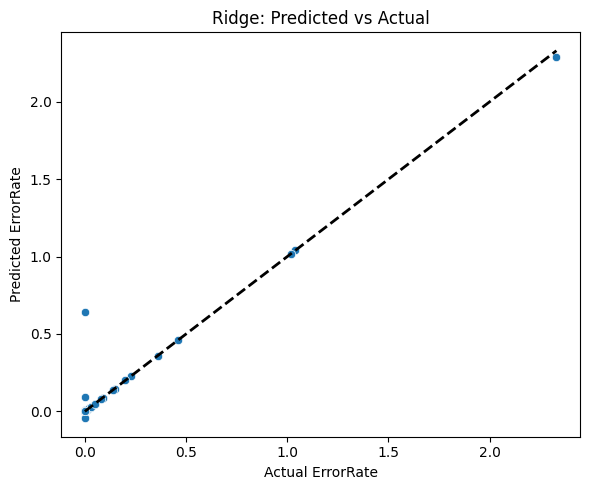

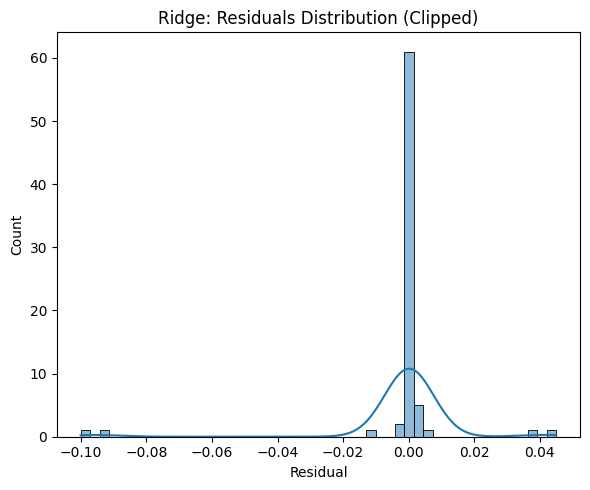

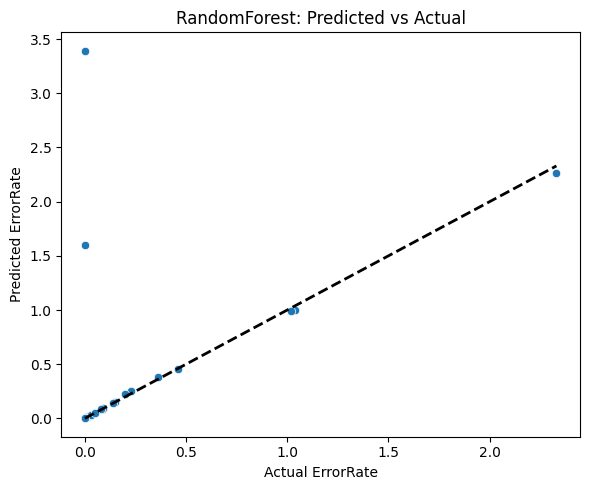

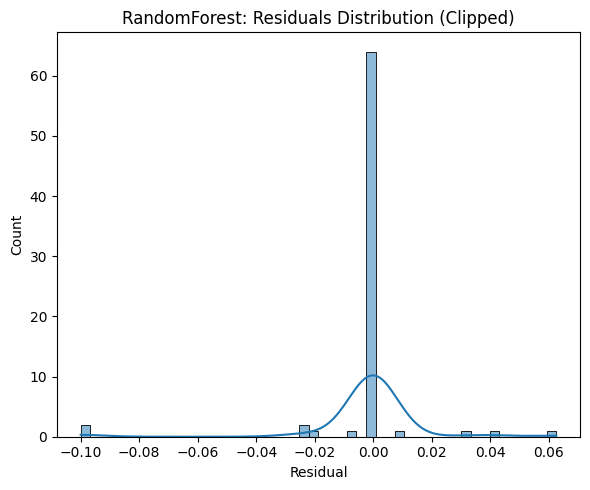

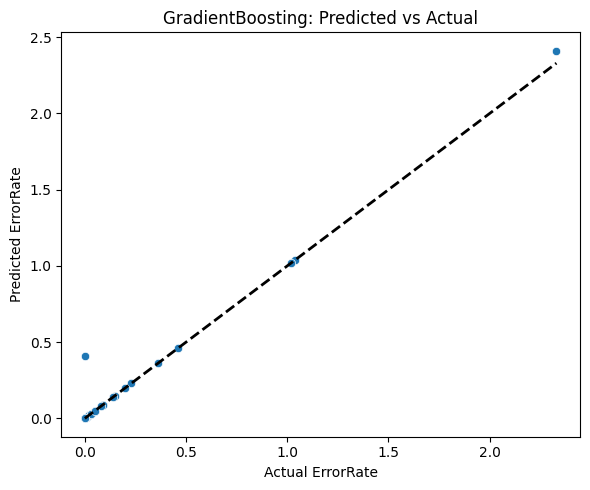

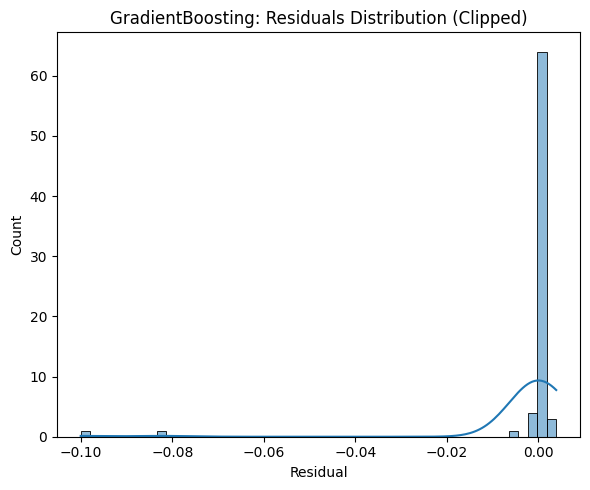

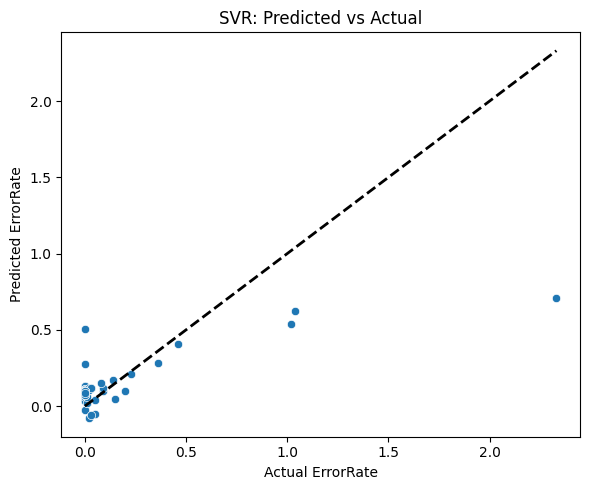

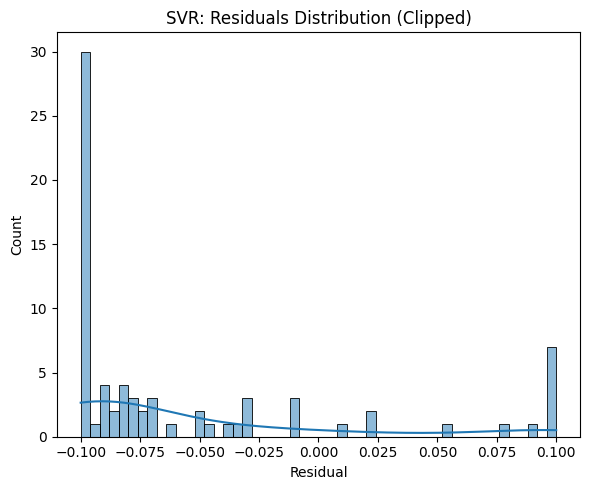

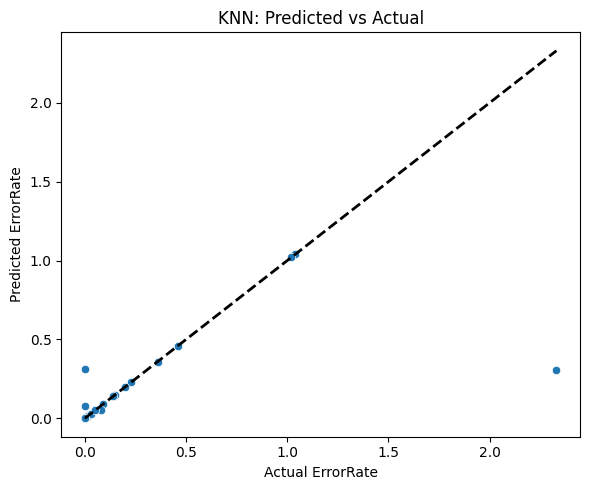

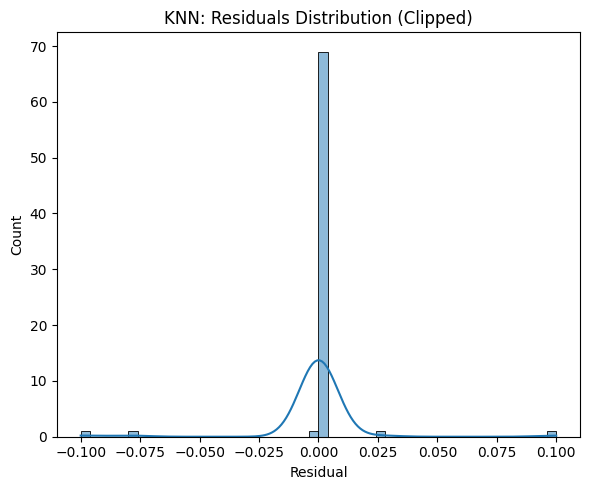

              Model       MSE       MAE        R2
2  GradientBoosting  0.002356  0.007068  0.976723
0             Ridge  0.005744  0.011735  0.943266
3               SVR  0.052123  0.119039  0.485143
4               KNN  0.056703  0.033121  0.439902
1      RandomForest  0.190311  0.070520 -0.879847


In [14]:
# Evaluate models on test set and collect metrics
metrics = []
for name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    metrics.append((name, mse, mae, r2))

    # Plot predicted vs actual
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel('Actual ErrorRate')
    plt.ylabel('Predicted ErrorRate')
    plt.title(f'{name}: Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.tight_layout()
    plt.show()

    # Residuals – clip extreme values for visualization
    residuals = y_test - y_pred
    residuals_clipped = np.clip(residuals, -0.1, 0.1)  # adjust clip limits as needed
    plt.figure(figsize=(6, 5))
    sns.histplot(residuals_clipped, bins=50, kde=True)
    plt.title(f'{name}: Residuals Distribution (Clipped)')
    plt.xlabel('Residual')
    plt.tight_layout()
    plt.show()

# Build summary dataframe
metrics_df = pd.DataFrame(metrics, columns=['Model', 'MSE', 'MAE', 'R2']).sort_values('R2', ascending=False)
print(metrics_df)


## Save Best Model and Inference Stub

We select the model with the highest R� and save it. We also provide a code stub to load the model and make predictions on new data.

In [15]:

# %%
# Save best model
best_model_name = metrics_df.iloc[0]['Model']
best_model = best_estimators[best_model_name]
joblib.dump(best_model, 'best_error_rate_model.pkl')

# Inference function with business rules
def predict_error_rate(new_feeder_path: str, new_parts_path: str) -> pd.DataFrame:
    """
    Predict error rates with enforced business rules:
    1. ErrorRate ≥ 0
    2. Missing PartNumber/Shape → ErrorRate = 0
    """
    # Load model
    model = joblib.load('best_error_rate_model.pkl')
    
    # Preprocessing pipeline
    def preprocess(df_fs, df_pu):
        # Feeder setup processing
        df_fs = df_fs.copy()
        df_fs.rename(columns={'PartShapeName': 'Shape'}, inplace=True)
        df_fs['Location'] = df_fs['Location'].astype(str).str.replace("'", "")
        df_fs['Position'] = 'M' + df_fs['ModuleNumber'].astype(str) + '-' + df_fs['Location']
        df_fs = explode_positions(df_fs)

        # Part usage processing
        df_pu = explode_positions(df_pu)

        # Validate merge columns
        required_merge_cols = ['Position', 'PartNumber', 'Shape']
        for df, name in zip([df_fs, df_pu], ['FeederSetup', 'PartUsage']):
            missing = [col for col in required_merge_cols if col not in df.columns]
            if missing:
                raise ValueError(f"Missing columns in {name}: {missing}")

        # Merge datasets
        merged = df_fs.merge(df_pu, on=required_merge_cols, how='left')
        
        # Cleanup columns
        merged = merged.drop(columns=[c for c in to_drop if c in merged.columns], errors='ignore')
        
        # Align columns with training data
        train_columns = X_train.columns.tolist()
        for col in train_columns:
            if col not in merged.columns:
                merged[col] = 0
                
        return merged[train_columns]

    # Process new data
    new_fs = pd.read_csv(new_feeder_path)
    new_pu = pd.read_csv(new_parts_path)
    processed_data = preprocess(new_fs, new_pu)

    # Generate predictions
    predictions = processed_data.copy()
    predictions['PredictedErrorRate'] = model.predict(processed_data)
    
    # Enforce business rules
    # 1. Identify invalid entries
    missing_mask = (
        predictions['PartNumber'].isna() | 
        (predictions['PartNumber'] == '') |
        predictions['Shape'].isna() |
        (predictions['Shape'] == '')
    )
    
    # 2. Apply rules
    predictions['PredictedErrorRate'] = (
        predictions['PredictedErrorRate']
        .clip(lower=0)  # Force non-negative
        .where(~missing_mask, 0)  # Set to 0 for missing IDs
    )
    
    return predictions[['Position', 'PartNumber', 'Shape', 'PredictedErrorRate']]

# Test with original data
try:
    predictions = predict_error_rate("FeederSetup.csv", "PartUsage.csv")
    print("Success! First 10 predictions:")
    print(predictions.head(10).to_markdown(index=False))
except Exception as e:
    print(f"Prediction failed: {str(e)}")

Success! First 10 predictions:
Prediction failed: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.


In [17]:
try:
    predictions = predict_error_rate("FeederSetup.csv", "PartUsage.csv")
    print("Success! First 10 predictions:")
    print(predictions.head(20).to_string(index=False))  # Changed to basic table format
except Exception as e:
    print(f"Prediction failed: {str(e)}")

Success! First 10 predictions:
Position         PartNumber              Shape  PredictedErrorRate
  M1.0-1                NaN                NaN            0.000000
  M1.0-2                NaN                NaN            0.000000
  M1.0-3                NaN                NaN            0.000000
  M1.0-4                NaN                NaN            0.000000
  M1.0-5                NaN                NaN            0.000000
  M1.0-6                NaN                NaN            0.000000
  M1.0-7                NaN                NaN            0.000000
  M1.0-8                NaN                NaN            0.000000
  M1.0-9                NaN                NaN            0.000000
 M1.0-10                NaN                NaN            0.000000
 M1.0-11   28-HF0016-MS01JR             C-0402            0.000171
 M1.0-12  19-GA1243-FTX01JR             R-0402            0.000171
 M1.0-13  19-GA5360-FTX01JR             R-0402            0.000171
 M1.0-14   28-BB0225-KS01JR    

## Optional: Feeder Configuration Optimization (Commented Out)

Below is an optional cell (commented out) that attempts to find a better PartNumber or Position for a given `Shape` by searching for configurations that minimize the predicted error rate.

In [28]:
# #Example: search for best feeder assignment for a given Shape
# #Note: This is an illustrative example and may need domain-specific logic.
# target_shape = 'r-0402'
# candidates = df[df['Shape'] == target_shape].copy()
# best_config = None
# best_pred = np.inf
# for _, row in candidates.iterrows():
#     candidate_df = row.to_frame().T  # single-row DataFrame
#     pred = best_model.predict(candidate_df)[0]
#     if pred < best_pred:
#         best_pred = pred
#         best_config = row
# print(f"Best configuration for {target_shape}: {best_config[['PartNumber', 'Position']].to_dict()} with predicted ErrorRate = {best_pred}")